# Binary Classification of Chest X-ray Images (Apple Silicon Optimized)

This notebook is optimized for Apple Silicon (M1/M2) using `tensorflow-macos`, `tensorflow-metal`, mixed precision, and efficient data loading with `tf.data.Dataset`.

## Dataset: ChestX-ray14 (CXR8)

- 112,120 frontal-view chest X-ray images
- 14 different thoracic pathology labels
- Binary classification: Normal vs Abnormal


## 1. Environment Setup (Apple Silicon)

- Uninstall regular TensorFlow: `pip uninstall -y tensorflow`
- Install: `pip install tensorflow-macos tensorflow-metal`

**Do this in your terminal, not in the notebook.**


In [13]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Enable mixed precision for Apple Silicon
mixed_precision.set_global_policy("mixed_float16")

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import warnings

# Training control flag
SKIP_TRAINING = True  # Set to True to skip training

# Load existing model if skipping training
if SKIP_TRAINING:
    try:
        model = tf.keras.models.load_model('best_model.keras')
        print("Loaded existing model from 'best_model.keras'")
    except:
        print("No existing model found. Please set SKIP_TRAINING = False to train.")
        SKIP_TRAINING = False

np.show_config()
np.random.seed(42)
warnings.filterwarnings("ignore", message=".*iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG*")


Loaded existing model from 'best_model.keras'
{
  "Compilers": {
    "c": {
      "name": "clang",
      "linker": "ld64",
      "version": "14.0.0",
      "commands": "cc",
      "args": "-fno-strict-aliasing, -DBLAS_SYMBOL_SUFFIX=64_, -DHAVE_BLAS_ILP64",
      "linker args": "-fno-strict-aliasing, -DBLAS_SYMBOL_SUFFIX=64_, -DHAVE_BLAS_ILP64"
    },
    "cython": {
      "name": "cython",
      "linker": "cython",
      "version": "3.0.8",
      "commands": "cython"
    },
    "c++": {
      "name": "clang",
      "linker": "ld64",
      "version": "14.0.0",
      "commands": "c++",
      "args": "-DBLAS_SYMBOL_SUFFIX=64_, -DHAVE_BLAS_ILP64",
      "linker args": "-DBLAS_SYMBOL_SUFFIX=64_, -DHAVE_BLAS_ILP64"
    }
  },
  "Machine Information": {
    "host": {
      "cpu": "aarch64",
      "family": "aarch64",
      "endian": "little",
      "system": "darwin"
    },
    "build": {
      "cpu": "aarch64",
      "family": "aarch64",
      "endian": "little",
      "system": "darwin"
   

/Users/m3/anaconda3/envs/tf-macos/lib/python3.9/site-packages/numpy/__config__.py:155: UserWarning: Install `pyyaml` for better output
  warnings.warn("Install `pyyaml` for better output", stacklevel=1)


## 2. Data Loading and Exploration


In [14]:
# Load the main dataset
data_path = '../datasets/CXR8/'
labels_df = pd.read_csv(os.path.join(data_path, 'Data_Entry_2017_v2020.csv'))
print(f'Dataset shape: {labels_df.shape}')
print(f'Columns: {list(labels_df.columns)}')
labels_df.head()


Dataset shape: (112120, 11)
Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Sex', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [15]:
# Explore the findings distribution
findings = labels_df['Finding Labels'].value_counts()
print(f'Total unique findings: {len(findings)}')
print('Top 10 findings:')
print(findings.head(10))

no_finding_count = len(labels_df[labels_df['Finding Labels'] == 'No Finding'])
abnormal_count = len(labels_df[labels_df['Finding Labels'] != 'No Finding'])
print(f'Normal (No Finding): {no_finding_count}')
print(f'Abnormal: {abnormal_count}')
print(f'Abnormal percentage: {abnormal_count/len(labels_df)*100:.1f}%')


Total unique findings: 836
Top 10 findings:
Finding Labels
No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: count, dtype: int64
Normal (No Finding): 60361
Abnormal: 51759
Abnormal percentage: 46.2%


Binary label distribution:
binary_label
0    60361
1    51759
Name: count, dtype: int64


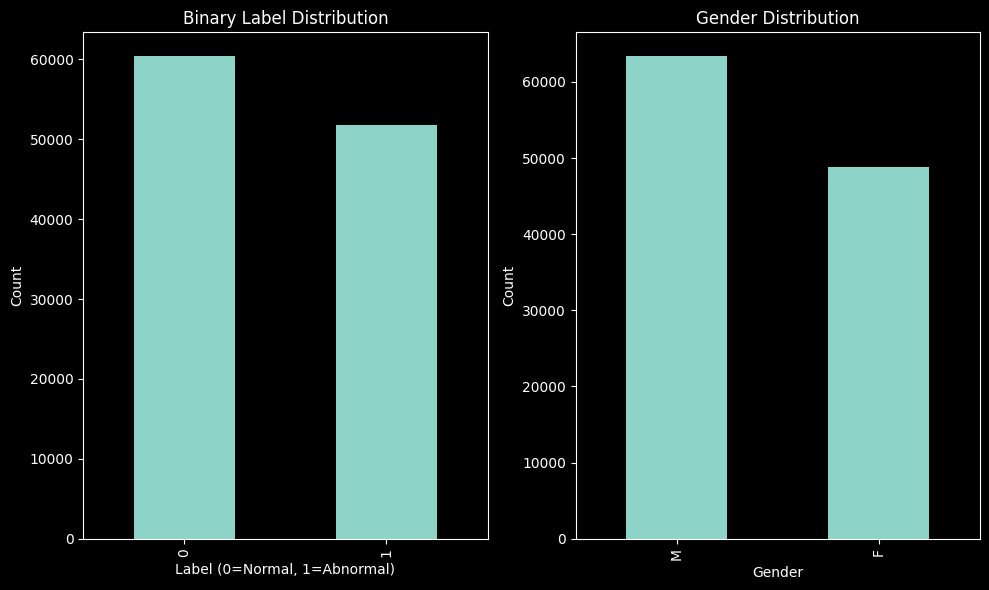

In [16]:
# Create binary labels
labels_df['binary_label'] = (labels_df['Finding Labels'] != 'No Finding').astype(int)
print('Binary label distribution:')
print(labels_df['binary_label'].value_counts())

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
labels_df['binary_label'].value_counts().plot(kind='bar')
plt.title('Binary Label Distribution')
plt.xlabel('Label (0=Normal, 1=Abnormal)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
labels_df['Patient Sex'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## 3. Data Preprocessing


In [17]:
# Create a balanced dataset
normal_samples = labels_df[labels_df['binary_label'] == 0]
abnormal_samples = labels_df[labels_df['binary_label'] == 1]
min_samples = min(len(normal_samples), len(abnormal_samples))
balanced_normal = normal_samples.sample(n=min_samples, random_state=42)
balanced_abnormal = abnormal_samples.sample(n=min_samples, random_state=42)
balanced_df = pd.concat([balanced_normal, balanced_abnormal]).reset_index(drop=True)
print(f'Balanced dataset shape: {balanced_df.shape}')
print(f'Normal samples: {len(balanced_normal)}')
print(f'Abnormal samples: {len(balanced_abnormal)}')


Balanced dataset shape: (103518, 12)
Normal samples: 51759
Abnormal samples: 51759


In [18]:
# Split the data
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42, stratify=balanced_df['binary_label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['binary_label'])

print(f'Training set: {len(train_df)} samples')
print(f'Validation set: {len(val_df)} samples')
print(f'Test set: {len(test_df)} samples')

print('Training set distribution:')
print(train_df['binary_label'].value_counts())
print('Validation set distribution:')
print(val_df['binary_label'].value_counts())
print('Test set distribution:')
print(test_df['binary_label'].value_counts())


Training set: 72462 samples
Validation set: 15528 samples
Test set: 15528 samples
Training set distribution:
binary_label
0    36231
1    36231
Name: count, dtype: int64
Validation set distribution:
binary_label
1    7764
0    7764
Name: count, dtype: int64
Test set distribution:
binary_label
0    7764
1    7764
Name: count, dtype: int64


## 4. Efficient Data Pipeline with tf.data.Dataset


In [ ]:
def preprocess_image(filename, label, img_dir, target_size=(224, 224)):
    image_path = tf.strings.join([img_dir, filename], separator='/')
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.cast(label, tf.float32)

def make_dataset(df, img_dir, batch_size=32, shuffle=True, target_size=(224, 224)):
    filenames = df['Image Index'].values
    labels = df['binary_label'].values
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.map(lambda f, l: preprocess_image(f, l, img_dir, target_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

image_dir = os.path.join(data_path, 'images/extracted_images')
train_ds = make_dataset(train_df, image_dir, batch_size=32, shuffle=True)
val_ds = make_dataset(val_df, image_dir, batch_size=32, shuffle=False)
test_ds = make_dataset(test_df, image_dir, batch_size=32, shuffle=False)


## 5. Model Building (Simple CNN)


In [20]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def create_simple_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        # Output layer must be float32 for mixed precision
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    return model

model = create_simple_cnn()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()


/Users/m3/anaconda3/envs/tf-macos/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,345 (10.78 MB)

 Trainable params: 2,825,345 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Tensorflow


In [21]:
if PYTORCH_TRAINING:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    from tqdm import tqdm

    class CXRDataset(Dataset):
        def __init__(self, df, img_dir, transform=None):
            self.df = df.reset_index(drop=True)
            self.img_dir = img_dir
            self.transform = transform
        def __len__(self):
            return len(self.df)
        def __getitem__(self, idx):
            img_name = self.df.loc[idx, 'Image Index']
            label = self.df.loc[idx, 'binary_label']
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert('L')
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.float32)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_dataset = CXRDataset(train_df, image_dir, transform)
    val_dataset = CXRDataset(val_df, image_dir, transform)
    test_dataset = CXRDataset(test_df, image_dir, transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    class SimpleCNN(nn.Module):
        def __init__(self):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
            self.fc1 = nn.Linear(64 * 28 * 28, 64)
            self.dropout1 = nn.Dropout(0.5)
            self.dropout2 = nn.Dropout(0.3)
            self.fc2 = nn.Linear(64, 1)
        def forward(self, x):
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            x = x.view(x.size(0), -1)
            x = torch.relu(self.fc1(x))
            x = self.dropout1(x)
            x = self.dropout2(x)
            x = torch.sigmoid(self.fc2(x))
            return x.squeeze(1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    epochs = 20
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Saved best model to best_model.pth')
    print('PyTorch training complete.')

    # Test evaluation (optional)
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f'Test Accuracy: {correct/total:.4f}')


✓ Loaded existing model from 'best_model.keras'
⏭️  Skipping training - using existing model


## 7. Evaluation


Evaluating model on test set...
329/486 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6334 - loss: 0.6698 - precision: 0.6588 - recall: 0.5727

2025-07-05 13:15:10.081051: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


486/486 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6343 - loss: 0.6691 - precision: 0.6579 - recall: 0.5752
Test Loss: 0.6671
Test Accuracy: 0.6364
Test Precision: 0.6534
Test Recall: 0.5809


2025-07-05 13:15:35.061861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


F1-Score: 0.6150
AUROC: 0.6809

Classification Report:
              precision    recall  f1-score   support

      Normal       0.62      0.69      0.66      7764
    Abnormal       0.65      0.58      0.62      7764

    accuracy                           0.64     15528
   macro avg       0.64      0.64      0.64     15528
weighted avg       0.64      0.64      0.64     15528



2025-07-05 13:15:47.223250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


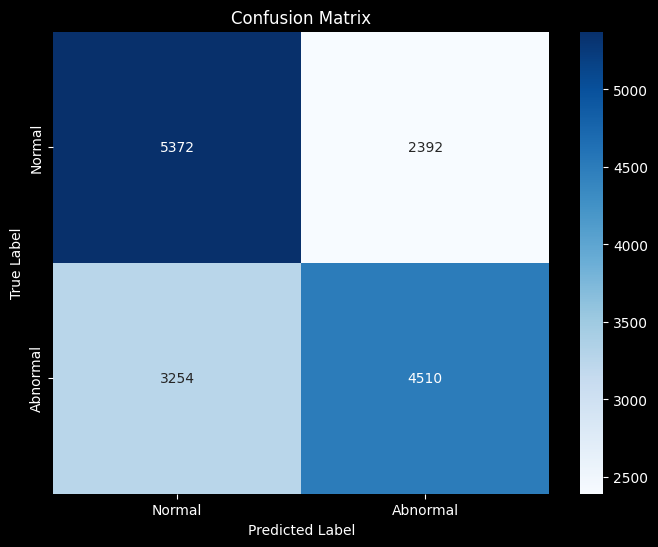

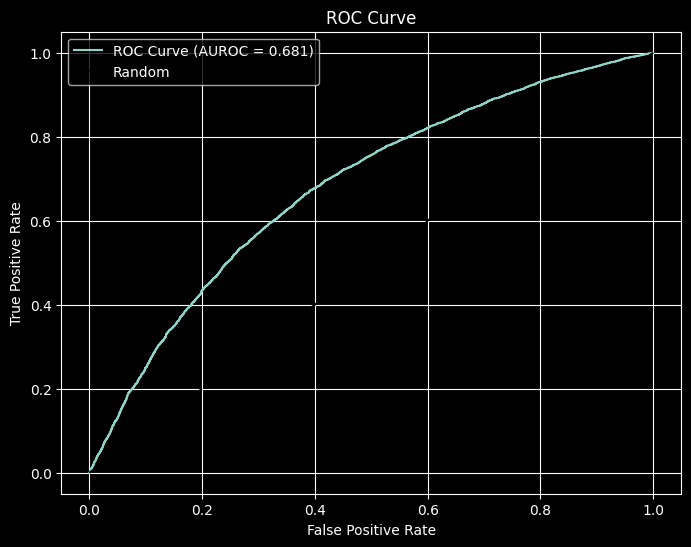

In [22]:
print("Evaluating model on test set...")
results = model.evaluate(test_ds, verbose=1, return_dict=True)
print(f'Test Loss: {results["loss"]:.4f}')
print(f'Test Accuracy: {results["accuracy"]:.4f}')
print(f'Test Precision: {results["precision"]:.4f}')
print(f'Test Recall: {results["recall"]:.4f}')

# Get predictions for additional metrics
y_true = []
y_pred_proba = []

for batch_images, batch_labels in test_ds:
    batch_pred = model.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred_proba.extend(batch_pred.flatten())

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

f1 = f1_score(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred_proba)

print(f'F1-Score: {f1:.4f}')
print(f'AUROC: {auroc:.4f}')

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))

def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Abnormal']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auroc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUROC = {auroc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_pred_proba)


## 8. Next Steps

- Try transfer learning (EfficientNet, ResNet, etc.)
- Add more data augmentation
- Implement explainable AI (Grad-CAM)
- Integrate patient metadata
